# News Article Summarizer
### Wellington da Silva
### 2022-09-03

## 1. Introduction

In this project I leverage [**Beautiful Soup**](https://www.crummy.com/software/BeautifulSoup/) and [**NLTK**](https://www.nltk.org/) to build a news article summarizer in **Python**.

First, the Beautiful Soup library is used to perform **web scraping** on the page we want to get the news article from. Then, I leverage the NLTK library to preprocess the text according to the **NLP pipeline** and build the summarizer.

## 2. Data acquisition:
### Exploring the Beautiful Soup library

I begin by loading the required libraries for this section:

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

In the following code snippet, I use the `Requests` library to send an HTTP request (GET) to get the news coverpage:

In [2]:
url = "https://noticias.uol.com.br/"
r = requests.get(url)
print(r.status_code)
coverpage = r.content

200


The `coverpage` object created in the previous step is then passed through `BeautifulSoup()` with the `html5lib` parser. The output is the page as a nested data structure, which is stored in the `soup` object:

In [3]:
soup = BeautifulSoup(coverpage, 'html5lib')

By inspecting the HTML code of the page, we can see that each news article corresponds to a `div class="thumbnails-wrapper"` element:

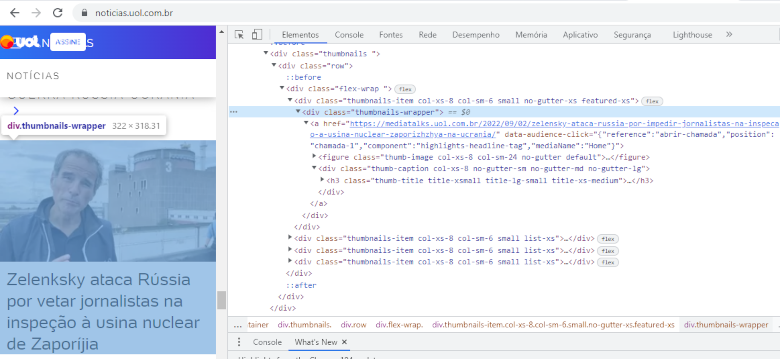

I then use the `find_all` method to search the page for the `div` tags that contain the `thumbnails-wrapper` CSS class:

In [4]:
coverpage_news = soup.find_all('div', class_='thumbnails-wrapper')

print('We have {} articles to read.'.format(len(coverpage_news)))

We have 46 articles to read.


With all the elements related to news articles stored in `coverpage_news`, we can use the same approach as above and iterate over this object to collect the URL (stored in an element with name `a` and attribute `href`), title (stored in an `h3` element), and the content of each article.

In order to retrieve the content (i.e. the article itself), the following code snippet makes a GET request to the URL of the corresponding article.
Then, the object created in this step is passed through `BeautifulSoup`.

The content is located in a `div class="text "` element, with each paragraph in a `p` child node.
The code below then also collects the text of all the paragraphs and concatenates them into a single string.

In [5]:
number_of_articles = 46
news_contents = []
list_links = []
list_titles = []

for n in np.arange(0, number_of_articles):
    
    # Getting the URL of the article
    link = coverpage_news[n].find('a')['href']
    list_links.append(link)
    
    # Getting the title
    title = coverpage_news[n].find('h3').get_text()
    list_titles.append(title)
    
    # Reading the content (it is divided in paragraphs)
    article = requests.get(link)
    article_content = article.content
    soup_article = BeautifulSoup(article_content, 'html5lib')
    body = soup_article.find_all('div', {"class": "text"})
    current = []
    for tag in body:
      tdTags = tag.find_all("p")
      for tag in tdTags:
        current.append(tag.text)

    big_string = ' '.join(current)
    news_contents.append(big_string)

print(news_contents[0])

O PTB formalizou hoje o pedido de registro de Padre Kelmon à Presidência da República pelo partido. O nome foi escolhido para substituir o do ex-deputado Roberto Jefferson (PTB), que teve a candidatura negada na última quinta-feira (1º). Os documentos foram protocolados junto ao TSE (Tribunal Superior Eleitoral) e o ministro Carlos Horbach é o relator do pedido.  Padre Kelmon era o vice de Jefferson na chapa do PTB, e havia sido aprovado pelo Tribunal Superior. Com isso, o pastor Luiz Cláudio Gamonal será o candidato a vice-presidente pela chapa. Como vice, o Padre havia declarado R$ 745.323,41 em bens ao TSE. O valor está dividido entre um depósito bancário em conta corrente no país, um montante aplicado na poupança, além de outros fundos e investimentos. A candidatura de Roberto Jefferson foi negada por unanimidade (7 votos a 0). O plenário do TSE entendeu que o ex-parlamentar está inelegível até dezembro de 2023 em razão de sua condenação no escândalo do Mensalão. Após a decisão, o 

## 3. Text Preprocessing and Analysis:
## Building the summarizer

In this section I use modules from the **NLTK** library to build a simple rule-based summarizer based on the algorithm by [Lima (2017)](https://medium.com/@empowerpython/utilizando-processamento-de-linguagem-natural-para-criar-um-sumariza%C3%A7%C3%A3o-autom%C3%A1tica-de-textos-775cb428c84e).

This summarizer is based on the assumption that **the more important a word is, the more it appears in the document**. So, the algorithm assigns a score to each sentence in the document according to the **frequency of the words** contained in it. It then retains the n top sentences ranked by this score.

Unlike [Lima (2017)](https://medium.com/@empowerpython/utilizando-processamento-de-linguagem-natural-para-criar-um-sumariza%C3%A7%C3%A3o-autom%C3%A1tica-de-textos-775cb428c84e), in this project I also take into account the number of words used to score each sentence in order to normalize the measure for the different sentence lengths.

As usual, we start by importing the required libraries and modules:

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.probability import FreqDist
from collections import defaultdict
from heapq import nlargest
from nltk.stem import SnowballStemmer

The following code snippet preprocess each news article according to the NLP pipeline, i.e., applying **tokenization**, **removing stopwords and special characters**, **stemming** the words and counting the **term frequencies** for each article.

It then score each sentence and retains the top 3 sentences according to this score.

In [7]:
pt_stemmer = SnowballStemmer('portuguese')
stopwords = set(stopwords.words('portuguese') + list(punctuation))
summarized = []

for n, article in enumerate(news_contents):
  if len(news_contents[n]) != 0:

    tmp = []

    # Tokenization into sentences and words
    original_sents = sent_tokenize(article, language='portuguese')
    original_words = word_tokenize(article.lower(), language='portuguese')

    # Stopwords and special characters removal
    original_words = [w for w in original_words if w not in stopwords and w.isalnum()]

    # Stemming
    stemmed_words = [pt_stemmer.stem(w) for w in original_words]
 
    # Word frequency counting
    article_freq = FreqDist(stemmed_words)
  
    # Iterates over all sentences and score them based on the frequency of each word
    important_sents = defaultdict(int)
    for i, sent in enumerate(original_sents):
    
      # Preprocess each sentence
      token_sent = word_tokenize(sent.lower(), language='portuguese')
      stemmed_sent = [pt_stemmer.stem(w) for w in token_sent]
    
      # Sums the frequencies of the words for the sentence, dividing by the number of words in it and
      # storing the result along with the sentence ID in the dict. object
      n_words = 0
      score = 0
      for w in stemmed_sent:
        if w in article_freq:
          n_words += 1
          score += article_freq[w]

      if n_words != 0:
        important_sents[i] = score/n_words
      else:
        important_sents[i] = 0

    # Stores the index of the top 3 sentences in the article according to the score
    idx_important_sents = nlargest(3, important_sents, important_sents.get)

    # Concatenates the 3 top sentences into a single string
    tmp.append(list_titles[n])
    tmp.append('\n')
    tmp.append(list_links[n])
    tmp.append('\n')
    for idx in sorted(idx_important_sents):
      tmp.append(original_sents[idx])
      tmp.append('\n')

    big_string = ' '.join(tmp)
    summarized.append(big_string)

Now, for the sake of visualization, let's compare a whole article with its summarized version:

In [40]:
# Displays the whole article for the sake of comparison
for i, sent in enumerate(sent_tokenize(news_contents[-18], language='portuguese')):
  print(i, sent)

0 Agentes federais e policiais dos EUA revistaram na quinta-feira duas propriedades em Nova York do bilionário russo Viktor Vekselberg, um aliado próximo do presidente sancionado Vladimir Putin, informou a NBC News.
1 Os policiais foram vistos carregando caixas depois de deixar um apartamento na sofisticada Park Avenue de Manhattan e uma casa em Hamptons, um destino de férias de luxo perto de Nova York, de acordo com a rede.
2 Ambas as propriedades estão ligadas a Vekselberg, disse a NBC, citando documentos do Tesouro dos EUA.
3 As autoridades também estão vasculhando uma propriedade em Fisher Island, em Miami, que acredita-se estar ligada a Vekselberg, informou a NBC.
4 Vekselberg é o chefe do Grupo Renova, um conglomerado com sede em Moscou e um dos bilionários russos alvo de sanções após a invasão da Ucrânia por Moscou.
5 As sanções congelaram os ativos de Vekselberg nos Estados Unidos e impediram as empresas americanas de fazer negócios com ele e suas empresas.


In [39]:
# Displays the summarized version
print(summarized[-8])

Polícia revista propriedades nos EUA de bilionário aliado de Putin 
 https://noticias.uol.com.br/ultimas-noticias/afp/2022/09/02/policia-revista-propriedades-nos-eua-de-bilionario-russo-sancionado.htm 
 Agentes federais e policiais dos EUA revistaram na quinta-feira duas propriedades em Nova York do bilionário russo Viktor Vekselberg, um aliado próximo do presidente sancionado Vladimir Putin, informou a NBC News. 
 Ambas as propriedades estão ligadas a Vekselberg, disse a NBC, citando documentos do Tesouro dos EUA. 
 As autoridades também estão vasculhando uma propriedade em Fisher Island, em Miami, que acredita-se estar ligada a Vekselberg, informou a NBC. 

